In [3]:
import librosa

In [4]:
y, sr = librosa.load("recording.wav", sr=None)  # y: waveform, sr: sample rate

In [5]:
hop_length = int(0.05 * sr)  # 50ms hop length

In [6]:
f0 = librosa.yin(y, fmin=196, fmax=1760, sr=sr, hop_length=hop_length)

In [7]:
import numpy as np

def freq_to_midi(freq):
    return 69 + 12 * np.log2(freq/440.0)

midi = freq_to_midi(f0)               # float MIDI #
midi_nearest = np.round(midi)         # nearest semitone
cents_off = (midi - midi_nearest) * 100  # cents deviation

In [8]:
times = librosa.frames_to_time(np.arange(len(f0)), sr=sr, hop_length=hop_length)

In [9]:
# onset_frames = librosa.onset.onset_detect(
#     y, sr=sr, hop_length=hop_length, backtrack=False
# )
# onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)


# Compute onset envelope first
onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)

# Now run onset detection
onset_frames = librosa.onset.onset_detect(
    onset_envelope=onset_env,
    sr=sr,
    hop_length=hop_length,
    backtrack=False
)
onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)


In [24]:
# import pandas as pd

# df = pd.DataFrame({
#     "time_s": times,
#     "freq_hz": f0,
#     "midi": midi,
#     "midi_nearest": midi_nearest,
#     "cents_off": cents_off,
# })
# # Mark rows that are onsets
# df["is_onset"] = df["time_s"].isin(onset_times)

import pandas as pd
import numpy as np

# Helper function to convert MIDI number to note name
# Needs to be fixed I guess
def midi_to_note_name(midi_number):
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 
                  'F#', 'G', 'G#', 'A', 'A#', 'B']
    midi_number = int(midi_number)
    note_index = midi_number % 12
    octave = (midi_number // 12) -1
    return f"{note_names[note_index]}{octave}"

# Generate note names for nearest MIDI notes
note_names = [midi_to_note_name(n) if not np.isnan(n) else None for n in midi_nearest]

# Create DataFrame
df = pd.DataFrame({
    "time_s": times,
    "freq_hz": f0,
    "midi": midi,
    "midi_nearest": midi_nearest,
    "note_name": note_names,
    "cents_off": cents_off,
})

# Mark rows that are onsets
df["is_onset"] = df["time_s"].isin(onset_times)


In [25]:
df[df["is_onset"]].head(20)

,time_s,freq_hz,midi,midi_nearest,note_name,cents_off,is_onset
1,0.05,195.918367,54.992990,55.0,G3,-0.701041,True
7,0.35,195.918367,54.992990,55.0,G3,-0.701041,True
16,0.80,440.206037,69.008105,69.0,A4,0.810487,True
17,0.85,438.622897,68.945731,69.0,A4,-5.426876,True
42,2.10,486.462173,70.737889,71.0,B4,-26.211078,True
68,3.40,557.536338,73.098748,73.0,C#5,9.874776,True
116,5.80,646.461620,75.660734,76.0,E5,-33.926565,True
117,5.85,654.576848,75.876709,76.0,E5,-12.329138,True
142,7.10,726.645287,77.684973,78.0,F#5,-31.502690,True
168,8.40,836.002946,80.112054,80.0,G#5,11.205403,True


Where's the D4? missed onset, let's dive into it:

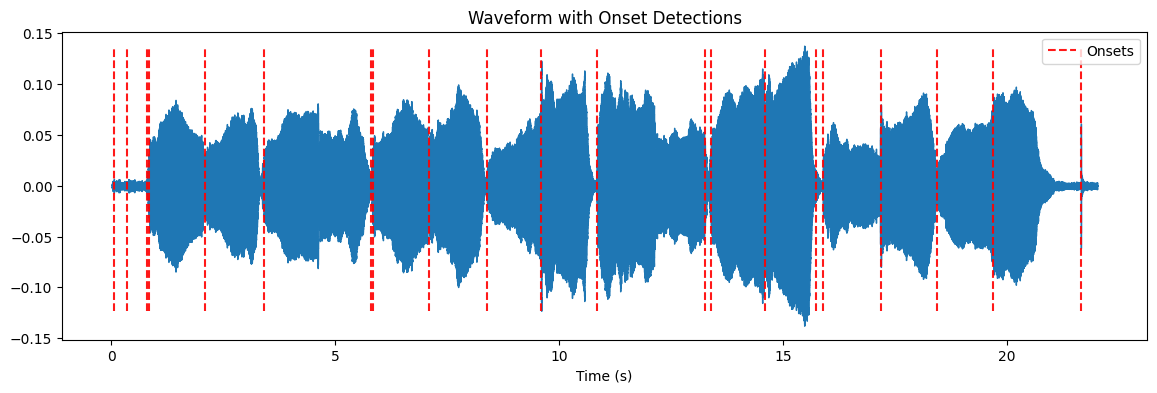

In [26]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.vlines(onset_times, ymin=min(y), ymax=max(y), color='r', alpha=0.9, linestyle='--', label="Onsets")
plt.title("Waveform with Onset Detections")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

so we can confirm that onset detection missed a clear note, 
actually G#4 in the return is also missed. both legato notes with a semitone of difference. 
clearly this is not the strenght of onset detection with librosa and we're gonna try pitch contour segmentation next.
but let's try a couple of ideas with the onset detection parameters, out of curiosity

In [28]:
onset_frames_sensitive = librosa.onset.onset_detect(
    onset_envelope=onset_env,
    sr=sr,
    hop_length=hop_length,
    delta=0.05,  # lower = more sensitive
)
onset_times_sensitive = librosa.frames_to_time(onset_frames_sensitive, sr=sr, hop_length=hop_length)
# Mark rows that are onsets
df["is_onset_sensitive"] = df["time_s"].isin(onset_times_sensitive)
df[df["is_onset_sensitive"]].head(20)


,time_s,freq_hz,midi,midi_nearest,note_name,cents_off,is_onset,is_onset_sensitive
1,0.05,195.918367,54.992990,55.0,G3,-0.701041,True,True
7,0.35,195.918367,54.992990,55.0,G3,-0.701041,True,True
16,0.80,440.206037,69.008105,69.0,A4,0.810487,True,True
17,0.85,438.622897,68.945731,69.0,A4,-5.426876,True,True
21,1.05,441.414944,69.055583,69.0,A4,5.558337,False,True
41,2.05,480.222509,70.514394,71.0,B4,-48.560596,False,True
42,2.10,486.462173,70.737889,71.0,B4,-26.211078,True,True
68,3.40,557.536338,73.098748,73.0,C#5,9.874776,True,True
92,4.60,564.286199,73.307083,73.0,C#5,30.708250,False,True
116,5.80,646.461620,75.660734,76.0,E5,-33.926565,True,True


the D is detected with the lowered delta -man I was out of tune!- but false positive detections have also increased.
and you know, you think you can somehow handle false positives that are distributed very closely to each other around one true positive. but something like time=10.15 here, could make a lot of trouble.

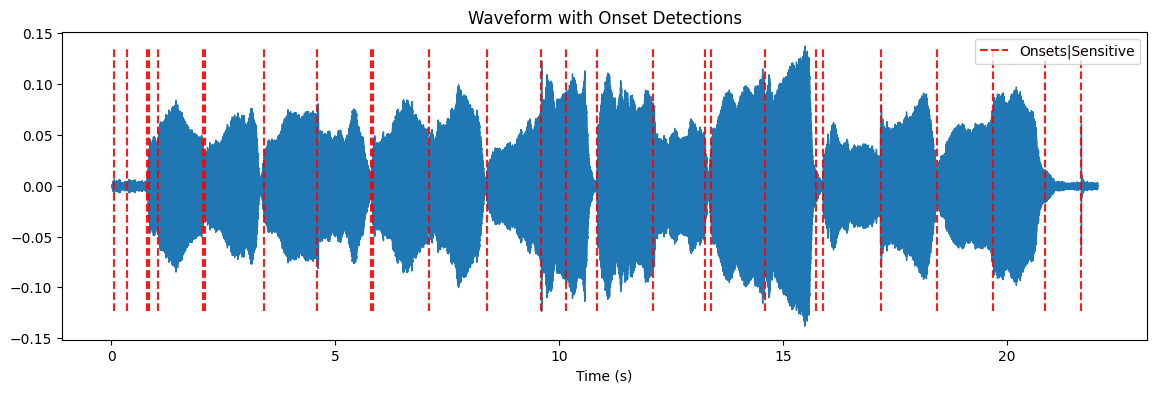

In [29]:
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.vlines(onset_times_sensitive, ymin=min(y), ymax=max(y), color='r', alpha=0.9, linestyle='--', label="Onsets|Sensitive")
plt.title("Waveform with Onset Detections")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

let's get one step deeper

In [30]:
onset_frames_tuned = librosa.onset.onset_detect(
    onset_envelope=onset_env,
    sr=sr,
    hop_length=hop_length,
    backtrack=True,        # optional: backtracks to local energy peak
    pre_max=10, post_max=10,
    pre_avg=50, post_avg=50,
    delta=0.05,            # lower delta = more sensitive
    wait=5
)
onset_times_tuned = librosa.frames_to_time(onset_frames_tuned, sr=sr, hop_length=hop_length)
# Mark rows that are onsets
df["is_onset_tuned"] = df["time_s"].isin(onset_times_tuned)
df[df["is_onset_tuned"]].head(20)

,time_s,freq_hz,midi,midi_nearest,note_name,cents_off,is_onset,is_onset_sensitive,is_onset_tuned
0,0.00,226.450846,57.500333,58.0,A#3,-49.966716,False,False,True
13,0.65,195.918367,54.992990,55.0,G3,-0.701041,False,False,True
39,1.95,441.278759,69.050241,69.0,A4,5.024138,False,False,True
67,3.35,544.359804,72.684684,73.0,C#5,-31.531578,False,False,True
91,4.55,558.485752,73.128203,73.0,C#5,12.820343,False,False,True
115,5.75,590.418377,74.090809,74.0,D5,9.080922,False,False,True
140,7.00,657.840764,75.962819,76.0,E5,-3.718137,False,False,True
167,8.35,748.651004,78.201478,78.0,F#5,20.147779,False,False,True
190,9.50,837.859315,80.150454,80.0,G#5,15.045396,False,False,True
216,10.80,892.185668,81.238085,81.0,A5,23.808539,False,False,True


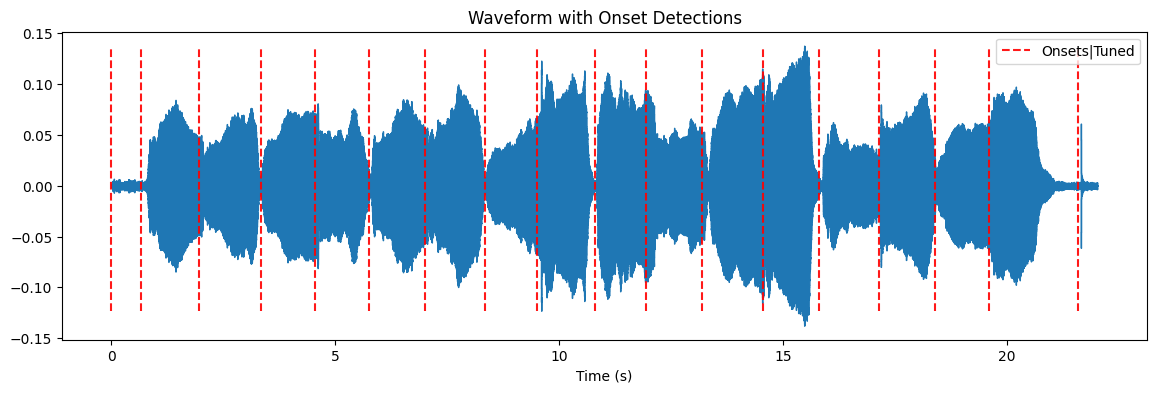

In [31]:
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.vlines(onset_times_tuned, ymin=min(y), ymax=max(y), color='r', alpha=0.9, linestyle='--', label="Onsets|Tuned")
plt.title("Waveform with Onset Detections")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

look how beautifully it works!\n
now the pitch contour segmentation

In [33]:
import numpy as np
import pandas as pd

def segment_pitch_contour(f0, times, cents_threshold=50, min_note_frames=3):
    segments = []
    current_segment = {"start_idx": None, "end_idx": None, "freqs": []}

    for idx, freq in enumerate(f0):
        if np.isnan(freq):  # Skip invalid pitch detection
            continue

        if current_segment["start_idx"] is None:
            # Start new segment
            current_segment["start_idx"] = idx
            current_segment["freqs"] = [freq]
            continue

        prev_freq = current_segment["freqs"][-1]
        cents_diff = 1200 * np.log2(freq / prev_freq)

        if abs(cents_diff) <= cents_threshold:
            # Same note continues
            current_segment["freqs"].append(freq)
            current_segment["end_idx"] = idx
        else:
            # Pitch jumped significantly, segment ends here
            if len(current_segment["freqs"]) >= min_note_frames:
                segments.append(current_segment.copy())
            # Start new segment
            current_segment = {
                "start_idx": idx,
                "end_idx": idx,
                "freqs": [freq],
            }

    # Append last segment
    if len(current_segment["freqs"]) >= min_note_frames:
        segments.append(current_segment.copy())

    # Convert segments into DataFrame
    rows = []
    for seg in segments:
        start_time = times[seg["start_idx"]]
        end_time = times[seg["end_idx"]]
        avg_freq = np.mean(seg["freqs"])
        midi_number = np.round(69 + 12 * np.log2(avg_freq / 440))
        cents_off = (69 + 12 * np.log2(avg_freq / 440) - midi_number) * 100
        rows.append({
            "start_time": start_time,
            "end_time": end_time,
            "avg_freq_hz": avg_freq,
            "midi_note": midi_number,
            "cents_off": cents_off,
        })

    return pd.DataFrame(rows)

# Run segmentation:
note_segments_df = segment_pitch_contour(f0, times)

# See results:
note_segments_df


,start_time,end_time,avg_freq_hz,midi_note,cents_off
0,0.05,0.50,195.918367,55.0,-0.701041
1,0.80,2.00,441.028721,69.0,4.042905
2,2.05,3.30,490.253061,71.0,-12.772263
3,3.35,4.60,557.588977,73.0,10.038221
4,4.65,5.75,590.278684,74.0,8.671266
5,5.95,7.05,657.496409,76.0,-4.624610
6,7.10,8.35,735.860062,78.0,-9.686505
7,8.40,12.10,866.317480,81.0,-27.129235
8,12.15,13.20,838.512235,80.0,16.393974
9,13.35,14.60,738.432971,78.0,-3.643863


current segmentation approach missed the G# (A-flat) note, probably because the pitch difference between G# (415.3 Hz) and A (440 Hz) (~100 cents) might be too subtle compared to the current threshold or pitch-detection resolution.
let's try lowering the cents treshold

In [34]:
note_segments_df_lowered_cent = segment_pitch_contour(f0, times, cents_threshold=35, min_note_frames=3)
note_segments_df_lowered_cent

,start_time,end_time,avg_freq_hz,midi_note,cents_off
0,0.05,0.50,195.918367,55.0,-0.701041
1,0.80,2.00,441.028721,69.0,4.042905
2,2.05,3.30,490.253061,71.0,-12.772263
3,3.40,4.60,558.118144,73.0,11.680429
4,4.65,5.75,590.278684,74.0,8.671266
5,5.95,7.05,657.496409,76.0,-4.624610
6,7.10,8.35,735.860062,78.0,-9.686505
7,8.40,9.55,837.922751,80.0,15.176467
8,9.65,12.10,880.088982,81.0,0.175046
9,12.15,13.20,838.512235,80.0,16.393974


found the G#, now the only note missing is the A5 with the right bow at 10.80 somewhere. and it's natural because no change of pitch happends there.
let's get a better visualization

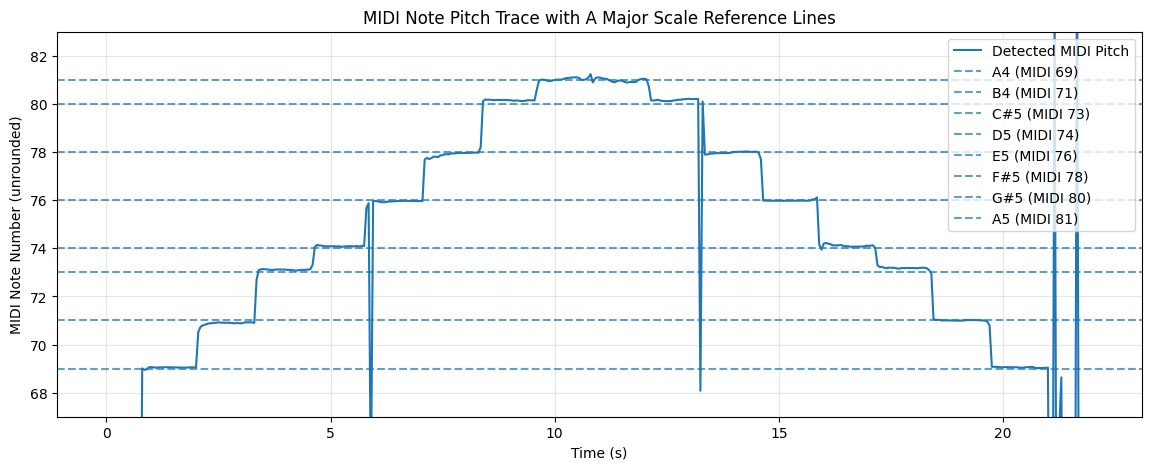

In [35]:
plt.figure(figsize=(14, 5))
plt.plot(times, midi, label='Detected MIDI Pitch', linewidth=1.5)

# Define the MIDI numbers for the notes of A major scale from A4 to A5
a_major_notes = {
    'A4': 69,
    'B4': 71,
    'C#5': 73,
    'D5': 74,
    'E5': 76,
    'F#5': 78,
    'G#5': 80,
    'A5': 81
}

# Add horizontal lines for each note
for note, midi_num in a_major_notes.items():
    plt.axhline(midi_num, linestyle='--', alpha=0.7, label=f'{note} (MIDI {midi_num})')

plt.xlabel('Time (s)')
plt.ylabel('MIDI Note Number (unrounded)')
plt.title('MIDI Note Pitch Trace with A Major Scale Reference Lines')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.ylim(67, 83)  # MIDI range from slightly below A4 to slightly above A5
plt.show()


as seen here, a pitch contour is not supposed to detect a 'new note' on the second A5, let's first check if these noises are a trouble to handle, and then I guess we'll come up with some solution to mix up the two methods.

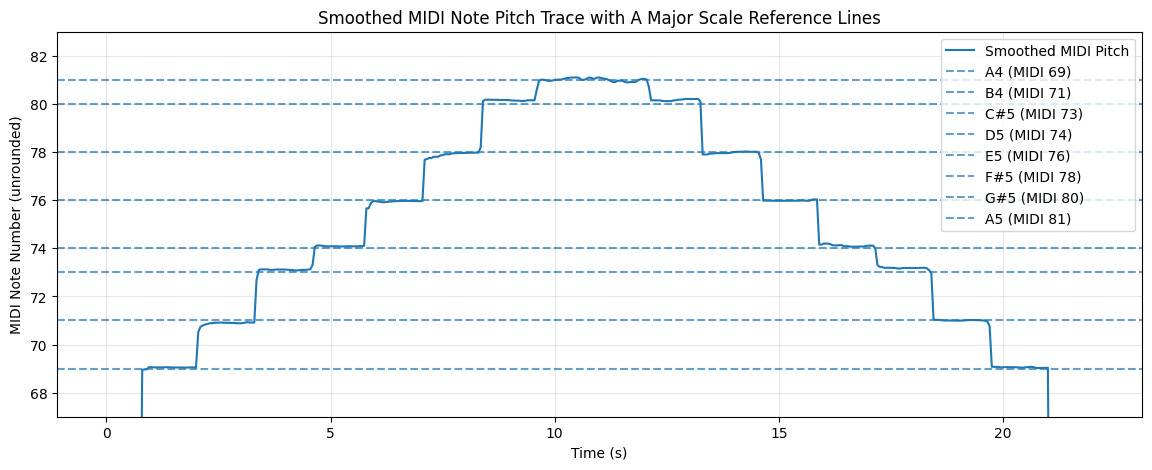

In [44]:
from scipy.ndimage import median_filter

# Apply a median filter on f0 to reduce noise and compute the corresponding smoothed MIDI pitch.
f0_smooth = median_filter(f0, size=3)
midi_smooth = freq_to_midi(f0_smooth)

note_segments_df_smooth = segment_pitch_contour(f0_smooth, times, cents_threshold=35, min_note_frames=2)

plt.figure(figsize=(14, 5))
plt.plot(times, midi_smooth, label='Smoothed MIDI Pitch', linewidth=1.5)

# Define the MIDI numbers for the notes of the A major scale from A4 to A5.
a_major_notes = {
    'A4': 69,
    'B4': 71,
    'C#5': 73,
    'D5': 74,
    'E5': 76,
    'F#5': 78,
    'G#5': 80,
    'A5': 81
}

# Add horizontal reference lines for each note.
for note, midi_num in a_major_notes.items():
    plt.axhline(midi_num, linestyle='--', alpha=0.7, label=f'{note} (MIDI {midi_num})')

plt.xlabel('Time (s)')
plt.ylabel('MIDI Note Number (unrounded)')
plt.title('Smoothed MIDI Note Pitch Trace with A Major Scale Reference Lines')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.ylim(67, 83)
plt.show()

In [45]:
note_segments_df_smooth

,start_time,end_time,avg_freq_hz,midi_note,cents_off
0,0.05,0.70,195.918367,55.0,-0.701041
1,0.80,2.00,440.994263,69.0,3.907635
2,2.05,3.30,490.248562,71.0,-12.788152
3,3.40,4.60,558.101922,73.0,11.630111
4,4.65,5.75,590.284432,74.0,8.688123
5,5.80,7.05,656.516773,76.0,-7.205984
6,7.10,8.35,735.859709,78.0,-9.687336
7,8.40,9.55,837.945990,80.0,15.224480
8,9.65,12.10,880.097163,81.0,0.191139
9,12.15,13.25,838.350256,80.0,16.059511


the noise in between the notes is easily removed in this case, the noise in the end of the file (probably when I put the violin on the table to hit 'stop recording') is still there. we'll proceed

to do later: mixing onset detection and pitch segmentation

next problem: how can I evaluate rythm without a metronome beep?

In [ ]:
## I guess I'll emplement something to process an image of my music sheet and convert it
##  to musicxml or somehow get these midi, offsetm, duration values, but right now I just
##  hardcode my A major scale in a string and read it with StringIO and pandas

from io import StringIO

data = """name	midi	offset	duration
A4	69	0	1
B4	71	1	1
C5#	73	2	1
D5	74	3	1
E5	76	4	1
F#5	78	5	1
G#5	80	6	1
A5	81	7	1
A5	81	8	1
G#5	80	9	1
F#5	78	10	1
E5	76	11	1
D5	74	12	1
C5#	73	13	1
B4	71	14	1
A4	69	15	1
"""

sheet_df = pd.read_csv(StringIO(data), sep="\t")
sheet_df

,name,midi,offset,duration
0,A4,69,0,1
1,B4,71,1,1
2,C5#,73,2,1
3,D5,74,3,1
4,E5,76,4,1
5,F#5,78,5,1
6,G#5,80,6,1
7,A5,81,7,1
8,A5,81,8,1
9,G#5,80,9,1
